In [73]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import statsmodels.tsa.seasonal as seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as stattools
import numpy as np
from pylab import rcParams
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [74]:
data = pd.read_csv('city_temperature.csv')
city = 'Belgrade'
selected_data = data[(data['City'] == city)]

# date = pd.to_datetime(selected_data[['Year', 'Month', 'Day']], dayfirst=True)
selected_data['Date'] = pd.to_datetime(selected_data[['Year', 'Month', 'Day']], dayfirst=True)
selected_data = selected_data[['Date', 'AvgTemperature', 'Year', 'Month']]
selected_data['Date']=pd.to_datetime(selected_data['Date'],infer_datetime_format=True)
selected_data = selected_data[selected_data['Date'] < '2020-01-01']

selected_data['Date']=pd.to_datetime(selected_data['Date'],infer_datetime_format=True)

# selected_data.head(selected_data['Date'].year == '2015-01-01:')
# selected_data.reset_index(drop=True, inplace=True)
# selected_data.set_index('Date', inplace=True)

In [75]:
selected_data[selected_data['Date'].between('2011-07-01','2011-07-31', inclusive=True)].head(5)

,Date,AvgTemperature,Year,Month
1002126,2011-07-01,63.5,2011,7
1002127,2011-07-02,59.4,2011,7
1002128,2011-07-03,66.0,2011,7
1002129,2011-07-04,69.2,2011,7
1002130,2011-07-05,70.1,2011,7


In [76]:
selected_data.head()
print(selected_data)

              Date  AvgTemperature  Year  Month
996101  1995-01-01            37.0  1995      1
996102  1995-01-02            34.3  1995      1
996103  1995-01-03            31.4  1995      1
996104  1995-01-04            30.1  1995      1
996105  1995-01-05            30.2  1995      1
...            ...             ...   ...    ...
1005228 2019-12-27            36.4  2019     12
1005229 2019-12-28            34.3  2019     12
1005230 2019-12-29            32.0  2019     12
1005231 2019-12-30            27.8  2019     12
1005232 2019-12-31            28.1  2019     12

[9132 rows x 4 columns]


In [77]:
selected_data.isnull().sum()

Date              0
AvgTemperature    0
Year              0
Month             0
dtype: int64

In [78]:
def change_f_to_c(f):
    c = round((f - 32)*5/9, 1)
    return c

In [79]:
change_f_to_c(selected_data['AvgTemperature'])
selected_data['AvgTemperatureC'] = change_f_to_c(selected_data['AvgTemperature'])

In [80]:
selected_data[selected_data['Date'].between('2018-08-01','2018-08-31', inclusive=True)].head()

,Date,AvgTemperature,Year,Month,AvgTemperatureC
1004715,2018-08-01,75.8,2018,8,24.3
1004716,2018-08-02,75.0,2018,8,23.9
1004717,2018-08-03,76.6,2018,8,24.8
1004718,2018-08-04,76.8,2018,8,24.9
1004719,2018-08-05,78.0,2018,8,25.6


In [81]:
# selected_data = selected_data[['AvgTemperatureC']]
selected_data.head()

,Date,AvgTemperature,Year,Month,AvgTemperatureC
996101,1995-01-01,37.0,1995,1,2.8
996102,1995-01-02,34.3,1995,1,1.3
996103,1995-01-03,31.4,1995,1,-0.3
996104,1995-01-04,30.1,1995,1,-1.1
996105,1995-01-05,30.2,1995,1,-1.0


In [82]:
selected_data = selected_data.resample('M', on='Date').mean()

In [83]:
selected_data['Month'] = selected_data['Month'].astype('int')
selected_data['Year'] = selected_data['Year'].astype('int')

In [84]:
selected_data.head()

,AvgTemperature,Year,Month,AvgTemperatureC
Date,,,,
1995-01-31,32.080645,1995,1,0.048387
1995-02-28,44.532143,1995,2,6.957143
1995-03-31,43.506452,1995,3,6.396774
1995-04-30,52.843333,1995,4,11.570000
1995-05-31,60.790323,1995,5,15.993548


In [85]:
selected_data.index
selected_data_1 = selected_data[['AvgTemperatureC']]

In [86]:
selected_data.head()

,AvgTemperature,Year,Month,AvgTemperatureC
Date,,,,
1995-01-31,32.080645,1995,1,0.048387
1995-02-28,44.532143,1995,2,6.957143
1995-03-31,43.506452,1995,3,6.396774
1995-04-30,52.843333,1995,4,11.570000
1995-05-31,60.790323,1995,5,15.993548


In [87]:
selected_data.loc['2010-07-31']

AvgTemperature       74.212903
Year               2010.000000
Month                 7.000000
AvgTemperatureC      23.448387
Name: 2010-07-31 00:00:00, dtype: float64

In [88]:
selected_data.head()

,AvgTemperature,Year,Month,AvgTemperatureC
Date,,,,
1995-01-31,32.080645,1995,1,0.048387
1995-02-28,44.532143,1995,2,6.957143
1995-03-31,43.506452,1995,3,6.396774
1995-04-30,52.843333,1995,4,11.570000
1995-05-31,60.790323,1995,5,15.993548


<AxesSubplot:xlabel='Date'>

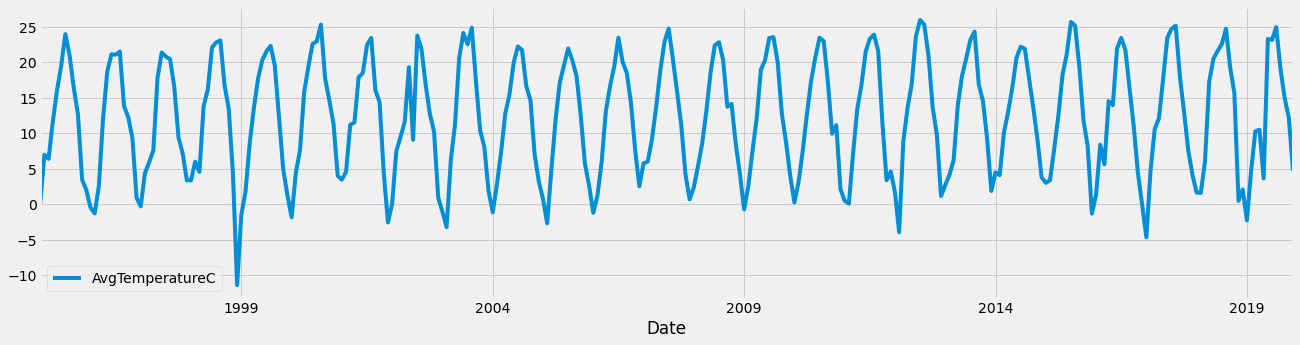

In [89]:
selected_data_1.plot(figsize=(20,5))
# sns.lineplot(x=selected_data.index, y=selected_data[['AvgTemperatureC']])

# plt.title('Average monthly temperature in {}'.format(city))
# plt.show()

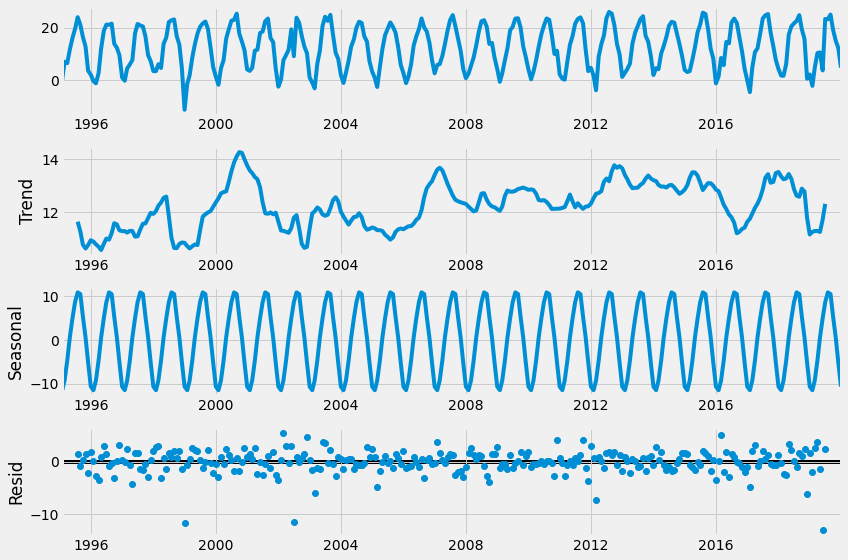

In [90]:
# check for stationarity - check whether mean, variance & covariance remain constant over time
# we use decomposition to check seasonality, trend residual
# seasonal_decompose.trend, resid, seasonality
rcParams['figure.figsize'] = 12, 8
decomposition = seasonal_decompose.seasonal_decompose(selected_data[['AvgTemperatureC']], model='additive')
fig = decomposition.plot()
# plt.tight_layout()

# plt.show()

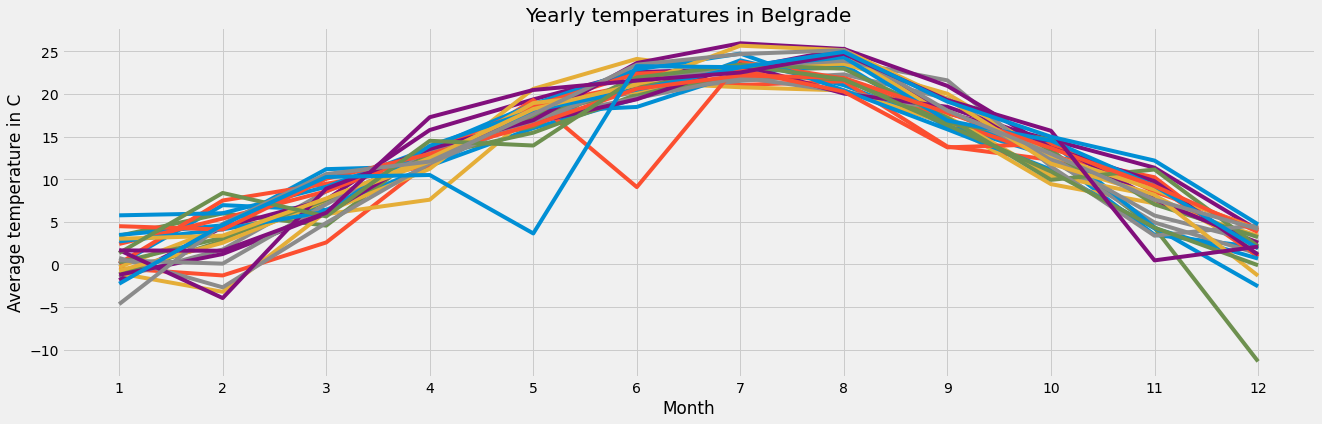

In [91]:
yearly = pd.pivot_table(selected_data, values='AvgTemperatureC', index='Month', columns='Year', aggfunc='mean')
yearly.plot(figsize=(20, 6))
plt.legend().remove()

plt.xlabel('Month')
plt.ylabel('Average temperature in C')
plt.title('Yearly temperatures in {}'.format(city))
plt.xticks([x for x in range(1, 13)])

plt.show()

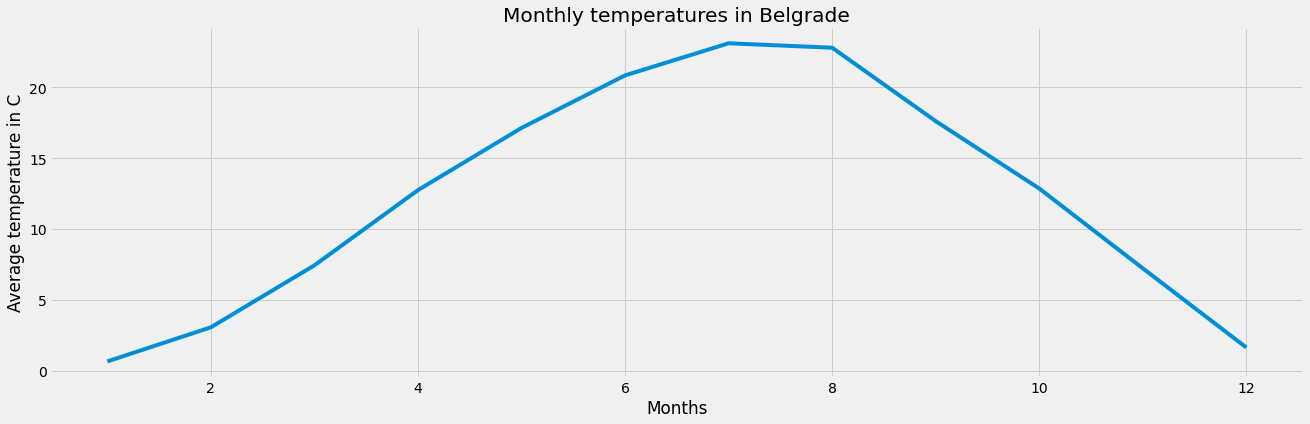

In [92]:
monthly = yearly.mean(axis=1)
monthly.plot(figsize=(20, 6))

plt.title('Monthly temperatures in {}'.format(city))
plt.xlabel('Months')
plt.ylabel('Average temperature in C')

plt.show()

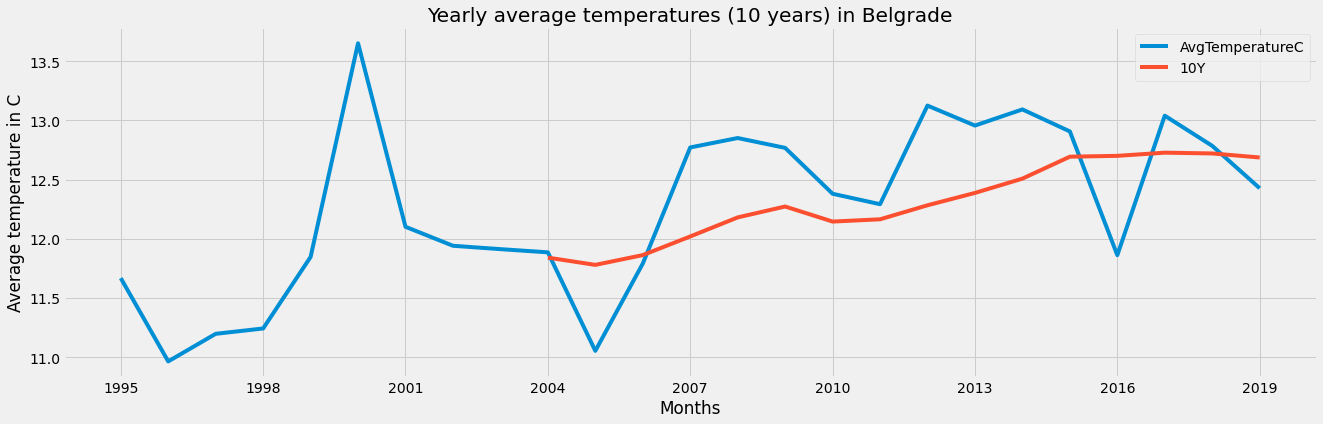

In [93]:
# we need to check whether there is a increasing/decreasing trend

yearly_average = pd.pivot_table(selected_data, values='AvgTemperatureC', index='Year', aggfunc=np.mean)
yearly_average['10Y'] = yearly_average['AvgTemperatureC'].rolling(10).mean()

yearly_average[['AvgTemperatureC',  '10Y']].plot(figsize=(20,6))
# yearly_average.head()
plt.title('Yearly average temperatures (10 years) in {}'.format(city))
plt.xlabel('Months')
plt.ylabel('Average temperature in C')

plt.xticks([x for x in range(1995,2020,3)])

plt.show()

In [94]:
print('Yearly min is: {}'.format(round(yearly_average['10Y'].min(), 2)))
print('Yearly max is: {}'.format(round(yearly_average['10Y'].max(), 2)))

Yearly min is: 11.78
Yearly max is: 12.73


In [95]:
# check for stationarity of the whole dataset

def check_for_stationarity(dataset):
    
    print('Dickey-Fuller test\n')

    dftest = stattools.adfuller(dataset['AvgTemperatureC'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    for k, v in dftest[4].items():
        dfoutput['critical value (%s)'%k]= v

    print(dfoutput)
    
    if dftest[0].round(2) < dftest[5].round(2):
        print('\nSerie seem to be stationary')
    else:
        print('\nSerie seem not to be stationary')
        
# according to the result below, test statistics value (-3.803853) is less than 5% critical value
# meaning that the data is stationary

In [96]:
check_for_stationarity(selected_data)

Dickey-Fuller test

Test Statistic                  -3.803853
p-value                          0.002868
#lags used                      16.000000
number of observations used    283.000000
critical value (1%)             -3.453670
critical value (5%)             -2.871808
critical value (10%)            -2.572241
dtype: float64

Serie seem to be stationary


In [97]:
TODO: def grid_search():
    pass